### This notebook takes about 4 hours to run (on Google Cloud)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pylab
from scipy import stats 
import copy
import math
from tqdm import tqdm

In [2]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import Video
import matplotlib as mpl

def build_animation(states, save_name):
    """
    A function that makes a very nice animation
    states: a list that contains all numpy arrays
    save_name: the name of the video
    Source: https://stackoverflow.com/questions/17212722/matplotlib-imshow-how-to-animate
    """
    
    fps = 35
    nSeconds = len(states)// fps

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = states[0]


    colors = ['white', 'darkblue', 'darkred',  'darkgreen', 'orange', 'black']
    bounds = [ 0,1,2,3,4, 5]

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    pylab.cla()
    im = pylab.imshow(a, interpolation='none', cmap=cmap, norm=norm)


    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(states[i])
        return [im]

    anim = animation.FuncAnimation(
                                   fig, 
                                   animate_func, 
                                   frames = nSeconds * fps,
                                   interval = 1000 / fps, # in ms
                                   )

    anim.save(save_name, fps=fps, extra_args=['-vcodec', 'libx264'])

    print('Done!')



In [3]:
def observe(config):
    """
    A function to observe the state of the CA
    config: the 2d grid
    """
    plt.figure(figsize = (10, 8))
    pylab.cla()
    pylab.imshow(config, vmin = 0, vmax = 4, cmap = pylab.cm.binary)

In [4]:

# the following vectorizers replace each cell in the CA by a lattice cell
vectorizer_0 = np.vectorize(lambda x: LatticeCell(0))
vectorizer_4 = np.vectorize(lambda x: LatticeCell(4))

def initialize(rows, columns):
    """
    A function to start the CA. It builds a hopper like container.
    rows, columns = the dimensions of the 2d grid
    """
    hole = int(0.03*columns) # the opening of the container
    config = np.zeros((rows, columns)).astype(object)
    show_config = np.zeros((rows, columns))
    for row in range(rows):
        for column in range(columns):
            config[row, column] = LatticeCell(0) #filling with empty cells
            show_config[row, column] =0
            
    # building the hopper: more black cells gradually from top to bottom        
    tile = 1
    for x in range(1, rows):
        if x == 0:
            continue
        if x %2 !=0:
            tile +=1
        for y in range(tile-1):
            config[x, y] = LatticeCell(4)
            config[x, -y-1] = LatticeCell(4)
            show_config[x, y] =4
            show_config[x, -y-1] =4
            
     
    config[-rows: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-rows: , int((columns/2)) : hole+int((columns/2))])
    config[-rows: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-rows: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])
    
    show_config[-rows: , int((columns/2)) : hole+int((columns/2))] =0
    show_config[-rows: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] =0
    
    
    
    #close:
    config[-2: , int((columns/2)) : hole+int((columns/2))] = vectorizer_4(config[-2: , int((columns/2)) : hole+int((columns/2))])
    config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_4(config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])

    show_config[-2: , int((columns/2)) : hole+int((columns/2))] = 4
    show_config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] =4
    
    return config, show_config

In [5]:
# all the possible sets of (v, o):
possible_states = [[0, 1], [0, 2], [0, 3],
                   [1, 1], [1, 2], [1, 3],
                   [2, 1],[2, 2], [2, 3],
                   [3, 1], [3, 2], [3, 3],
                   [4, 1], [4, 2], [4, 3],
                   [5, 1], [5, 2], [5, 3]]

In [6]:

def v_coordinates(coord_list, v):
    """
    A function to get the coordinate of a neighbor cell using the current coordinate 
    and the direction
    coord_list: the list of all possible coordinates
    v: the direction
    """
    row, column = coord_list
    if v == 0: #rest
        return([row, column])
    
    elif v == 1: #right
        return([row, column+1])
    
    elif v == 2: #bottom right
        return([row+1, column+1])

    elif v == 3: # bottom 
        return([row+1, column])
    
    elif v == 4: #bottom left
        return([row+1, column-1])
    
    elif v == 5: # left
        return([row, column-1])

    

In [7]:
class GrainParticle:
    """
    A class for the granular particles. It contains their velocity direction, their oreitnation,
    position, and energy
    """
    def __init__(self, position,current_v, current_o):
        self.current_v = current_v
        self.next_v = None
        self.current_o = current_o
        self.next_o = None
        self.next_E = None
        self.position = position
        self.destination =None 
        
        
class LatticeCell:
    """
    A general class to be placed in the numpy array and contain the particles or act as walls
    """ 
    def __init__(self, value):
        self.value = value
        self.particle = []
        self.incoming_particles = []

In [8]:
# the matrix to find the values of F_v

                         #0 1 2 3 4 5   
motion_matrix= np.array([[0.0,0.1,0.2,0.1,0.2,0.1],
                         [0.1,0.0,0.1,0.2,0.3,0.2],
                         [0.2,0.1,0.0,0.1,0.2,0.3],
                         [0.1,0.2,0.1,0.0,0.1,0.2],
                         [0.2,0.3,0.2,0.1,0.0,0.1],
                         [0.1,0.2,0.3,0.2,0.1,0.0]])

In [9]:

def interaction_step(config, particles, emptying = False):
    """
    The first step in the model. This step is used to calculate the v and o for the grains.
    config: the 2d grid
    particles: a list that contains all particles
    emptying: whether the hopper is open for emptying or closed
    """
    
    active_sites = [] # the sites in which particles will travel to
    
    for particle in particles:
        
        row, column = particle.position
        
        
        # neighbors of one grain:
        neighbors = [[row-1, column-1], [row-1, column], [row-1, column+1], [row, column-1],
                        [row, column+1], [row+1, column-1], [row+1, column],[row+1, column+1]]
            
        # getting the cells that have grain (not walls or empty)    
        non_empty_neighbors = [i for i in neighbors if config[i[0],i[1]].value !=0 and  config[i[0],i[1]].value !=4]
        below_sites = [config[i, j].value for i, j in neighbors[-3:]]
        
        # getting the empty cells
        any_empty= [i for i in neighbors if config[i[0],i[1]].value ==0 ]
        
        # if the particle is fully surronded by particles then it can't move anywhere
        if not any_empty:
            continue
            
        # iterate over all possible combinations and get the energy for that combination   
        hold_Es = []
        hold_states = []
        for v, o in possible_states:
            
            next_coord = v_coordinates([row, column], v)
            if v != 0 and config[next_coord[0], next_coord[1]].value != 0:
                continue # if there is no empty space to move to
                
            
            if below_sites[0] == 0 or below_sites[1] == 0  or below_sites[2] == 0:
                
                if v != 4 and v != 3 and v != 2: # the gravity effect
                    
                    E_G = 3
                    
                else:
                    E_G = 0
            else:
                E_G = 0

            if below_sites[1] ==0 and v!= 3:
                E_G = 3
            
            
            # calculating the relative motion effect using the matrix
            F_Vs = [ (motion_matrix[v,config[i, j].particle[0].current_v] +0.1) for \
                            i,j in non_empty_neighbors] 
            
            # calculating the relative orientation effect
            F_Os = [s if config[i,j].particle[0].current_o== o else 1 for i,j in non_empty_neighbors]
            
            
            # calculating the dilation effect
            if config[row-1, column].value ==1 and emptying and config[row+1, column].value ==1:
                if config[row, column-1].value ==0 and v!=5:
                    F_D = 1.1
                
                elif config[row, column+1].value ==0 and v!=1:
                    F_D = 1.1
                else:
                    F_D = 0.2
            else:
                F_D = 0.2
           
             # finally, calculating the energy of that combination
            F_Vs = np.array(F_Vs)**alpha
            F_Os = np.array(F_Os)**Beta
            F_Ds = F_D**gamma
            E_I =F_Vs * F_Os * F_Ds
            E_i = E_G+ sum(E_I)
            hold_Es.append(E_i)
            hold_states.append([v, o])
            
        if hold_Es:
            # choosing the combiation that gives the minimum energy
            minimum_states = np.array(hold_states)[np.where(np.array(hold_Es) == np.array(hold_Es).min())]
            #print(minimum_states)
            #print("\n")
            choesn_state =  random.choice(minimum_states)
            v, o = choesn_state
            if 0 in minimum_states[:, 0]:
                v = 0
                o = config[row, column].particle[0].current_o
            
            
            config[row, column].particle[0].next_v = v
            config[row, column].particle[0].next_o = o
            config[row, column].particle[0].next_E = min(hold_Es)
            next_row, next_column = v_coordinates([row, column],v)
            config[row, column].particle[0].destination = [next_row, next_column]
            
            config[next_row, next_column].incoming_particles.append(config[row, column].particle[0])
            if [next_row, next_column] not in active_sites:
                active_sites.append([next_row, next_column])
            
        # if there was no space to move, just put everything to rest
        else:
            
            config[row, column].particle[0].next_v = 0
            config[row, column].particle[0].next_o = config[row, column].particle[0].current_o
            config[row, column].particle[0].next_E = 0
            config[row, column].particle[0].destination = [row, column]
            
        
    return config, particles, active_sites

In [10]:
def propagation_step(config, particles, active_sites):
    """
    The second main step in the model. In this step, particles will move one cell towards
    their direction of motion
    config: the 2d grid
    particles: the list of all particles
    active_sites: the list of cells at which particles will go to (collision happens there)
    """
    
    for site in active_sites: #iterating over the sites at which particles will move 
        row, column = site
        
        
        # if there are more than one partice coming to one cell, choos the one with min energy
        if len(config[row, column].incoming_particles) >1:
            all_array = np.array(config[row, column].incoming_particles)
            all_Es = np.array([i.next_E for i in all_array])
            competing_particles = all_array[np.where(all_Es == all_Es.min())]
            # if more than one with same minimum energy then choose one random
            incoming_particle =  random.choice(competing_particles)
            
        else: #if only one particle coming to the cell then just move it
            incoming_particle = config[row, column].incoming_particles[0]
        
        
        # move the particles and update all the attributes to the new position
        old_row, old_column = incoming_particle.position
        config[old_row, old_column] = LatticeCell(0)
        show_config[old_row, old_column] = 0
       
        config[row, column].particle =[incoming_particle] 
        config[row, column].incoming_particles = []
        config[row, column].value = 1
        show_config[row, column] = incoming_particle.next_o
        
        incoming_particle.position = [row, column]
        incoming_particle.current_v = incoming_particle.next_v
        incoming_particle.current_o = incoming_particle.next_o
        
    return config, particles

## Starting with a test:

In [11]:
s = 0.01
alpha = 3
Beta = 1
gamma = 2

# tester
particles = [GrainParticle([24, 25], 3, 1), GrainParticle([25, 25], 3, 1), GrainParticle([26, 25], 3, 1)]


config, show_config = initialize(50, 50)
for particle in particles:
    row, column = particle.position
    config[row, column].value = 1
    config[row, column].particle = [particle]
    show_config[row, column] = particle.current_o
    

states = []
states.append(np.array(show_config))
for i in range(100):
    
    config, particles, active_sites = interaction_step(config, particles)
    config, particles = propagation_step(config, particles, active_sites)
    states.append(np.array(show_config))


...Done!


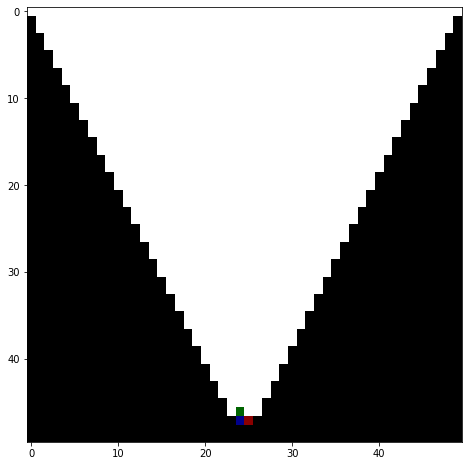

In [12]:
build_animation(states, "baxter1.mp4")

In [13]:
from IPython.display import Video
Video("baxter1.mp4")

## The case when the orientation is not considered (beta =0)

In [14]:
# the filling step: raining partices

s = 0.01
alpha = 3
Beta = 0
gamma = 2


rows = columns  = 250
hole = int(0.02*columns)
config, show_config = initialize(rows, columns)
#rain = np.linspace(90, 160, 45, dtype=int)

rain = np.linspace(75, 175, 60, dtype=int)

particles = []
states = []
states.append(np.array(show_config))


In [15]:
s = 0.01
alpha = 3
Beta = 0
gamma = 2

for i in tqdm(range(1000)): #1000
    
    if i%5==0 and i<900: #900
        new_cells = [LatticeCell(1) for j in range(len(rain))]
        new_particles = [GrainParticle([2, column],3, random.choice([1, 2, 3])) for column in rain]
        [new_cells[ind].particle.append(partic) for ind, partic in enumerate(new_particles)]
        np.put(config[2], rain, new_cells)
        particles+= new_particles
    config, particles, active_sites = interaction_step(config, particles)
    config, particles = propagation_step(config, particles, active_sites)
    states.append(np.array(show_config))
    
    

100%|██████████| 1000/1000 [07:56<00:00,  2.10it/s]


.............................Done!


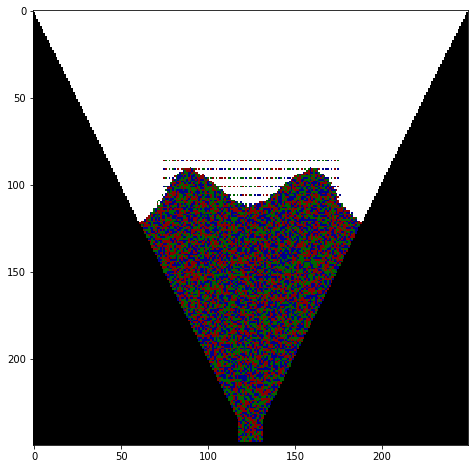

In [16]:
build_animation(states, "baxter2.mp4")

In [17]:
from IPython.display import Video
Video("baxter2.mp4")

In [18]:
#The emptying step:

#open
config[-2: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-2: , int((columns/2)) : hole+int((columns/2))])
config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])

#open
show_config[-2: , int((columns/2)) : hole+int((columns/2))] = 0
show_config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = 0
states_empty = []
counter = []

In [19]:
for i in tqdm(range(1000)):
 
    config, particles, active_sites = interaction_step(config, particles, emptying=True)
    config, particles = propagation_step(config, particles, active_sites)
    states_empty.append(np.array(show_config))
    
    
    l1 = sum([len(i.particle) for i in config[-2: , int((columns/2)) : hole+int((columns/2))].ravel()])
    l2 = sum([len(i.particle) for i in config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel()])
    counter.append(l1+l2)
    #remove
    [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)) : hole+int((columns/2))].ravel() if i.particle]
    [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel() if i.particle]
    #empty
    config[-1: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-1: , int((columns/2)) : hole+int((columns/2))])
    config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])
    show_config[-1: , int((columns/2)) : hole+int((columns/2))] = 0
    show_config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1]=0


100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


.............................Done!


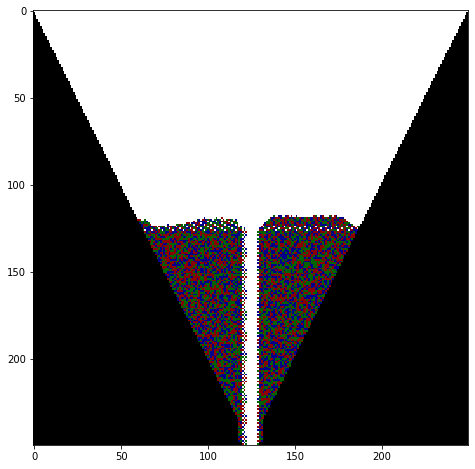

In [20]:
build_animation(states_empty, "baxter1_empty.mp4")

In [21]:
from IPython.display import Video
Video("baxter1_empty.mp4")

## The case when the orientation is considered.

In [22]:

rows = columns  = 250
hole = int(0.02*columns)
config, show_config = initialize(rows, columns)

rain = np.linspace(90, 160, 45, dtype=int)

#rain = np.linspace(75, 175, 40, dtype=int)

particles = []
states = []
states.append(np.array(show_config))


In [23]:
s = 0.01
alpha = 3
Beta = 1
gamma = 2

for i in tqdm(range(1900)):#1900
    
    if i%5==0 and i<1100: #1100
        new_cells = [LatticeCell(1) for j in range(len(rain))]
        new_particles = [GrainParticle([2, column],3, random.choice([1, 2, 3])) for column in rain]
        [new_cells[ind].particle.append(partic) for ind, partic in enumerate(new_particles)]
        np.put(config[2], rain, new_cells)
        particles+= new_particles
    config, particles, active_sites = interaction_step(config, particles)
    config, particles = propagation_step(config, particles, active_sites)
    states.append(np.array(show_config))
    
    

100%|██████████| 1900/1900 [08:23<00:00,  3.78it/s]


.......................................................Done!


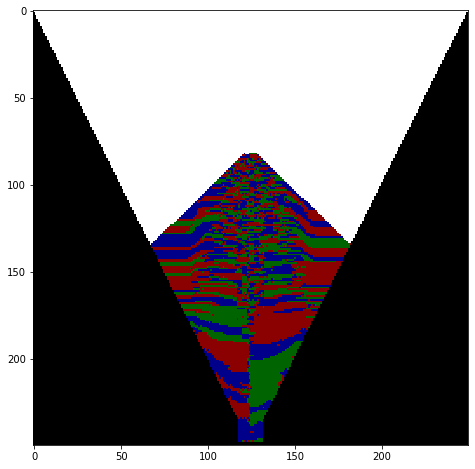

In [24]:
build_animation(states, "baxter3.mp4")

In [25]:
from IPython.display import Video
Video("baxter3.mp4")

In [26]:
#emptying

#open
config[-2: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-2: , int((columns/2)) : hole+int((columns/2))])
config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])

#open
show_config[-2: , int((columns/2)) : hole+int((columns/2))] = 0
show_config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = 0
states_empty = []
counter = []

In [27]:
for i in tqdm(range(1900)):
 
    config, particles, active_sites = interaction_step(config, particles, emptying=True)
    config, particles = propagation_step(config, particles, active_sites)
    states_empty.append(np.array(show_config))
    
    
    l1 = sum([len(i.particle) for i in config[-2: , int((columns/2)) : hole+int((columns/2))].ravel()])
    l2 = sum([len(i.particle) for i in config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel()])
    counter.append(l1+l2)
    #remove
    [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)) : hole+int((columns/2))].ravel() if i.particle]
    [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel() if i.particle]
    #empty
    config[-1: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-1: , int((columns/2)) : hole+int((columns/2))])
    config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])
    show_config[-1: , int((columns/2)) : hole+int((columns/2))] = 0
    show_config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1]=0


100%|██████████| 1900/1900 [15:56<00:00,  1.99it/s]


.......................................................Done!


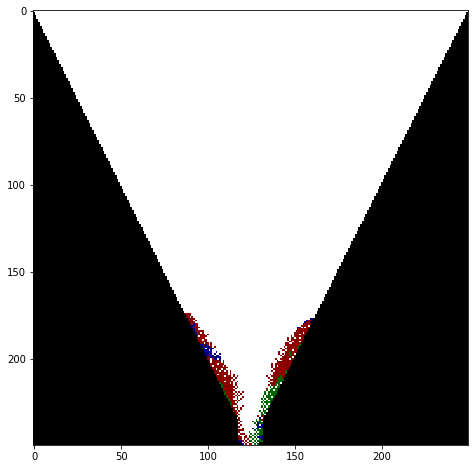

In [28]:
build_animation(states_empty, "baxter4.mp4")

In [29]:
Video("baxter4.mp4")

## Generating the flow rate plots over 5 iterations

In [30]:



all_counters = []
for iteration in range(5):
    
    rows = columns  = 100
    hole = int(0.03*columns)
    config, show_config = initialize(rows, columns)
    rain = np.linspace(30, 70, 20, dtype=int)

    #rain = np.linspace(100, 150, 25, dtype=int)

    particles = []
    states = []
    #states.append(np.array(show_config))

    for i in range(1000):

        if i%5==0 and i<820:
            new_cells = [LatticeCell(1) for j in range(len(rain))]
            new_particles = [GrainParticle([2, column],3, random.choice([1, 2, 3])) for column in rain]
            [new_cells[ind].particle.append(partic) for ind, partic in enumerate(new_particles)]
            np.put(config[2], rain, new_cells)
            particles+= new_particles
        config, particles, active_sites = interaction_step(config, particles)
        config, particles = propagation_step(config, particles, active_sites)
        #states.append(np.array(show_config))

    #open
    config[-2: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-2: , int((columns/2)) : hole+int((columns/2))])
    config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])

    #open
    show_config[-2: , int((columns/2)) : hole+int((columns/2))] = 0
    show_config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = 0


    states_empty = []
    counter = []


    for i in range(1150):

        config, particles, active_sites = interaction_step(config, particles, emptying=True)
        config, particles = propagation_step(config, particles, active_sites)
        #states_empty.append(np.array(show_config))


        l1 = sum([len(i.particle) for i in config[-1: , int((columns/2)) : hole+int((columns/2))].ravel()])
        l2 = sum([len(i.particle) for i in config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel()])
        counter.append(l1+l2)
        #remove
        [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)) : hole+int((columns/2))].ravel() if i.particle]
        [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel() if i.particle]
        #empty
        config[-1: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-1: , int((columns/2)) : hole+int((columns/2))])
        config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])
        show_config[-1: , int((columns/2)) : hole+int((columns/2))] = 0
        show_config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1]=0

    
    all_counters.append(counter)
    print(f"{iteration} done")
    
    
    plt.show()


0 done
1 done
2 done
3 done
4 done


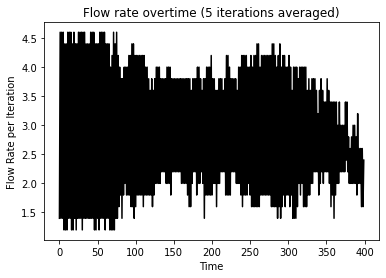

In [38]:
plt.plot(np.mean(np.array(all_counters), axis=0)[700:1100], color = 'black')
plt.title("Flow rate overtime (5 iterations averaged)")
plt.xlabel("Time")
plt.ylabel("Flow Rate per Iteration")
plt.show()

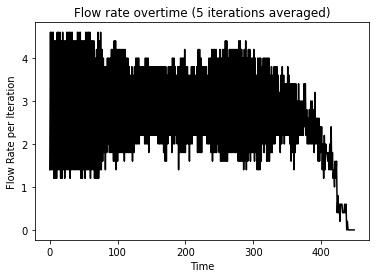

In [36]:
plt.plot(np.mean(np.array(all_counters), axis=0)[700:], color = 'black')
plt.title("Flow rate overtime (5 iterations averaged)")
plt.xlabel("Time")
plt.ylabel("Flow Rate per Iteration")
plt.show()

## Generating the flow rate plots over 11 iterations

In [32]:

all_counters11 = []
for iteration in range(11):
    
    rows = columns  = 100
    hole = int(0.03*columns)
    config, show_config = initialize(rows, columns)
    rain = np.linspace(30, 70, 20, dtype=int)

    #rain = np.linspace(100, 150, 25, dtype=int)

    particles = []
    states = []
    #states.append(np.array(show_config))

    for i in range(1000):

        if i%5==0 and i<820:
            new_cells = [LatticeCell(1) for j in range(len(rain))]
            new_particles = [GrainParticle([2, column],3, random.choice([1, 2, 3])) for column in rain]
            [new_cells[ind].particle.append(partic) for ind, partic in enumerate(new_particles)]
            np.put(config[2], rain, new_cells)
            particles+= new_particles
        config, particles, active_sites = interaction_step(config, particles)
        config, particles = propagation_step(config, particles, active_sites)
        #states.append(np.array(show_config))

    #open
    config[-2: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-2: , int((columns/2)) : hole+int((columns/2))])
    config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])

    #open
    show_config[-2: , int((columns/2)) : hole+int((columns/2))] = 0
    show_config[-2: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = 0


    states_empty = []
    counter = []


    for i in range(1150):

        config, particles, active_sites = interaction_step(config, particles, emptying=True)
        config, particles = propagation_step(config, particles, active_sites)
        #states_empty.append(np.array(show_config))


        l1 = sum([len(i.particle) for i in config[-1: , int((columns/2)) : hole+int((columns/2))].ravel()])
        l2 = sum([len(i.particle) for i in config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel()])
        counter.append(l1+l2)
        #remove
        [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)) : hole+int((columns/2))].ravel() if i.particle]
        [particles.remove(i.particle[0]) for i in config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1].ravel() if i.particle]
        #empty
        config[-1: , int((columns/2)) : hole+int((columns/2))] = vectorizer_0(config[-1: , int((columns/2)) : hole+int((columns/2))])
        config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1] = vectorizer_0(config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1])
        show_config[-1: , int((columns/2)) : hole+int((columns/2))] = 0
        show_config[-1: , int((columns/2)-1)-hole+1 : int((columns/2)-1)+1]=0

    
    all_counters11.append(counter)
    print(f"{iteration} done")
    
    plt.show()

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done


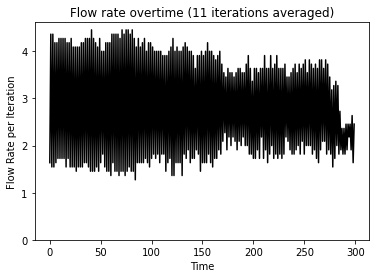

In [34]:
plt.plot(np.mean(np.array(all_counters11), axis=0)[800:1100], color = 'black')
plt.ylim(0)
plt.title("Flow rate overtime (11 iterations averaged)")
plt.xlabel("Time")
plt.ylabel("Flow Rate per Iteration")
plt.show()

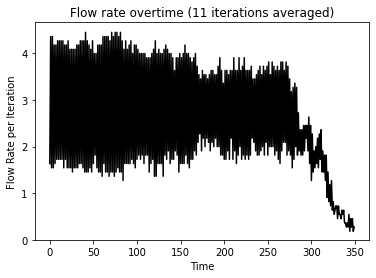

In [37]:
plt.plot(np.mean(np.array(all_counters11), axis=0)[800:], color = 'black')
plt.ylim(0)
plt.title("Flow rate overtime (11 iterations averaged)")
plt.xlabel("Time")
plt.ylabel("Flow Rate per Iteration")
plt.show()